# 17. 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

* 오토인코더(AutoEncoder; AE)

  오토인코더는 지도 없이도 잠재표현 또는 코딩이라부르는 입력데이터의 밀집 표현을 학습할 수 있는 인공신경망이다. 

  코딩은 일반적으로 훨씬 낮은 차원을 가지므로 차원 축소 또는 강력한 특성 추출기로 작동하여, 심층 신경망의 비지도 사전훈련에 사용될 수 있다는 것이다. 그리고 훈련 데이터와 매우 비슷한 새로운 데이터를 생성할 수 있는 생성모델의 역할을 수행한다.

  AE는 입력을 출력으로 복사하는 방법을 배우는 신경망이다. 그러나 의도와 달리 신경망이 간단히 복사한 입력을 출력으로 사용할 수 있으므로, 잠재 표현(은닉층)의 크기를 제한하거나 입력에 잡음을 추가하여 이를 방지한다. 이러한 제약은 위의 상황을 방지하고 데이터를 효율적으로 표현하도록 한다.

* 생성적 적대 신경망(Generative Adversarial Network; GAN)

  GAN은 생성자와 판별자 신경망 두 개로 구성된다. 생성자는 훈련 데이터와 비슷하게 보이는 데이터를 생성한다. 판별자는 가짜 데이터와 진짜 데이터를 구분한다. 둘의 목적은 서로 적대적이고, 결과적으로는 진짜와 같은 이미지를 생성하기 때문에 생성적 적대 신경망이라고 불린다.

  GAN은 초해상도, 이미지를 컬러 변환, 이미지 편집 및 변환,동영상 프레임 예측, 데이터 증식, 여러 다른 종류의 데이터 생성 등의 모델의 취약점을 식별하고 개선하는 등에 널리 사용된다. 

## 17.1. 오토인코더(AutoEncoder; AE)

<div align="center">
<img src="imgs/AE_architecture.jpg" />
<p style="font-size:20px">AutoEncoder Architecture</p>
</div>

AutoEncoder는 처음에 말했던 것과 같이 Encoder부와 Decoder부로 나뉘며, Encoder에서 효율적인 내부 표현으로 바꾸고 Decoder를 통해 입력과 가장 가까운 어떤 것을 출력한다. Decoder를 통해 입력을 복원하는 것을 reconstruction이라고 하고, AE는 결과적으로 reconstruction loss를 줄임으로써 학습을 수행한다.

## 17.3. 적층 오토인코더(stacked or deep AE)

<div align="center">
<img src="imgs/AE_stacked_architecture.png" />
<p style="font-size:20px">Stacked(Deep) AutoEncoder Architecture</p>
</div>

적층 오토인코더는 Encoder와 Decoder로 사용되는 신경망이 여러층으로 구성된 AE를 말한다. 신경망이 너무 깊어지는 경우, 오토인코더가 더 복잡한 코딩을 학습할 수 있지만, 너무 강력해지지 않도록 유의해야 한다.

인코더가 너무 강력하여 각각의 입력데이터를 임의의 한 숫자로 매핑하게 되면, 다른 데이터셋에 대해 표현을 하지 못하여 즉, 일반화가 되지 않는 문제가 발생한다.

적층 오토인코더의 손실함수로는 MSELoss 대신 BCELoss를 사용한다. 재구성 작업을 이진 분류 뮨제로 다루는 것이다. 회귀문제가 아니지만 이런식으로 문제를 정의하는 경우 수렴이 빨라지는 경향이 있다.

In [275]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [276]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

MNIST = load_digits()
X_data = MNIST["data"]
y_target = MNIST["target"]
target_names = MNIST["target_names"]

class MNIST_Dataset(Dataset):
  def __init__(self, X_data, y_target, transform=None):
    super(MNIST_Dataset, self).__init__()
    assert X_data.shape[0] == y_target.shape[0]
    self.X = X_data
    self.y = y_target

  def __getitem__(self,index):
    img = torch.Tensor(self.X[index])
    label = self.y[index]

    img = (img - img.min()) / (img.max() - img.min())

    return img,label

  def __len__(self):
    return self.X.shape[0]

In [277]:
dataset = MNIST_Dataset(X_data,y_target,data_transform)

epochs = 1000
batch_size = 16
train_ratio=0.8
test_ration = 1-train_ratio
len_train = int(X_data.shape[0]*train_ratio)
len_test = X_data.shape[0] - len_train

train_dataset, test_dataset= torch.utils.data.random_split(dataset,[len_train, len_test], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [278]:
class StackedAutoEncoder(nn.Module):
  def __init__(self):
    super(StackedAutoEncoder,self).__init__()

    self.stacked_encoder = nn.Sequential(
                                    nn.Linear(8*8,16),
                                    nn.SELU(),
                                    nn.Linear(16,4),
                                    nn.SELU()
                                )

    self.stacked_decoder = nn.Sequential(
                                    nn.Linear(4,16),
                                    nn.SELU(),
                                    nn.Linear(16,8*8),
                                    nn.Sigmoid()
                                )
  def forward(self, x):
    encoded = self.stacked_encoder(x)
    decoded = self.stacked_decoder(encoded)
    return decoded

model = StackedAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.015)

In [279]:
from tqdm import tqdm_notebook

for epoch in tqdm_notebook(range(epochs)):
  model.train()
  total_loss = []
  for idx, (input,label) in enumerate(train_dataloader):
    output = model(input)
    loss = criterion(output, input)
    total_loss.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("epochs: {}|{}; {:.4f}".format(epoch,epochs,sum(total_loss)/len(train_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


epochs: 0|1000; 0.6891
epochs: 1|1000; 0.6742
epochs: 2|1000; 0.6611
epochs: 3|1000; 0.6471
epochs: 4|1000; 0.6318
epochs: 5|1000; 0.6151
epochs: 6|1000; 0.5973
epochs: 7|1000; 0.5788
epochs: 8|1000; 0.5603
epochs: 9|1000; 0.5422
epochs: 10|1000; 0.5250
epochs: 11|1000; 0.5094
epochs: 12|1000; 0.4954
epochs: 13|1000; 0.4832
epochs: 14|1000; 0.4728
epochs: 15|1000; 0.4642
epochs: 16|1000; 0.4571
epochs: 17|1000; 0.4513
epochs: 18|1000; 0.4466
epochs: 19|1000; 0.4429
epochs: 20|1000; 0.4399
epochs: 21|1000; 0.4376
epochs: 22|1000; 0.4356
epochs: 23|1000; 0.4342
epochs: 24|1000; 0.4328
epochs: 25|1000; 0.4318
epochs: 26|1000; 0.4309
epochs: 27|1000; 0.4301
epochs: 28|1000; 0.4296
epochs: 29|1000; 0.4290
epochs: 30|1000; 0.4285
epochs: 31|1000; 0.4281
epochs: 32|1000; 0.4277
epochs: 33|1000; 0.4274
epochs: 34|1000; 0.4271
epochs: 35|1000; 0.4269
epochs: 36|1000; 0.4266
epochs: 37|1000; 0.4264
epochs: 38|1000; 0.4262
epochs: 39|1000; 0.4260
epochs: 40|1000; 0.4258
epochs: 41|1000; 0.4258
ep

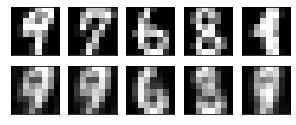

In [280]:
f,a = plt.subplots(2,5,figsize=(5,2))

for i in range(5):
  img = test_dataset[i][0].data.numpy().reshape(8,8)
  a[0][i].imshow(img,cmap="gray")
  a[0][i].set_xticks(()); a[0][i].set_yticks(())

for i in range(5):
  img = model(test_dataset[i][0].data).detach().numpy().reshape(8,8)
  a[1][i].imshow(img,cmap="gray")
  a[1][i].set_xticks(()); a[1][i].set_yticks(())

## 17.3.4. 적층 오토인코더를 사용한 비지도 사전 훈련 (Unsupervised Pre-training)

레이블된 훈련 데이터가 많지 않은 복잡한 지도학습 문제의 경우에, 비슷한 문제를 학습한 신경망을 찾아 하위층을 재사용하는 것은 좋은 방법 중 하나이다. 이로 인해 저수준의 특성을 학습할 필요가 없기 때문에 적은 훈련데이터를 사용하여 고성능 모델을 훈련할 수 있다. 즉, 기존 네트워크에서 학습한 특성 감지 기능을 재사용하는 것이다. 

전체 데이터를 사용하여 적층 오토인코더를 훈련한 후, 하위층을 재사용하여 실제 문제 해결을 위한 신경망을 만들고 레이블된 데이터를 사용하여 훈련한다.

분류기를 훈련할 때, 레이블된 훈련데이터가 많지 않은 경우 사전 훈련층(적어도 하나의 가장 하위층)을 동결하는 것도 좋다.

In [281]:
class UnspAEClassifier(nn.Module):
  def __init__(self, target_names):
    super(UnspAEClassifier,self).__init__()
    self.stacked_encoder = nn.Sequential(
                                nn.Linear(8*8,16),
                                nn.SELU(),
                                nn.Linear(16,4),
                                nn.SELU(),
                                nn.Linear(4, len(target_names)),
                                nn.Softmax(dim=0)
                            )
  def forward(self, x):
    return self.stacked_encoder(x)

(unfreezing) copy weight and bias from pretrained model

In [283]:
unsp_model = UnspAEClassifier(target_names)

model_params = dict(model.named_parameters())
unsp_model_params= dict(unsp_model.named_parameters())

# copying weights and bias from pretrained model
# https://discuss.pytorch.org/t/copy-weights-only-from-a-networks-parameters/5841
for key, params in model_params.items():
  if key in unsp_model_params:
    print("copy weight {}".format(key))
    unsp_model_params[key].data.copy_(params.data)

copy weight stacked_encoder.0.weight
copy weight stacked_encoder.0.bias
copy weight stacked_encoder.2.weight
copy weight stacked_encoder.2.bias


In [285]:
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unsp_model.parameters(),lr=0.001)

In [286]:
for epoch in tqdm_notebook(range(epochs)):
  unsp_model.train()
  total_loss = []
  for idx, (input, label) in enumerate(train_dataloader):
    output = unsp_model(input)
    loss = criterion(output,label)
    total_loss.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("epochs: {}|{}; {:.4f}".format(epoch,epochs,sum(total_loss)/len(train_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


epochs: 0|1000; 2.3108
epochs: 1|1000; 2.3103
epochs: 2|1000; 2.3094
epochs: 3|1000; 2.3102
epochs: 4|1000; 2.3099
epochs: 5|1000; 2.3106
epochs: 6|1000; 2.3097
epochs: 7|1000; 2.3095
epochs: 8|1000; 2.3089
epochs: 9|1000; 2.3091
epochs: 10|1000; 2.3089
epochs: 11|1000; 2.3087
epochs: 12|1000; 2.3079
epochs: 13|1000; 2.3087
epochs: 14|1000; 2.3084
epochs: 15|1000; 2.3082
epochs: 16|1000; 2.3079
epochs: 17|1000; 2.3076
epochs: 18|1000; 2.3071
epochs: 19|1000; 2.3072
epochs: 20|1000; 2.3068
epochs: 21|1000; 2.3070
epochs: 22|1000; 2.3064
epochs: 23|1000; 2.3060
epochs: 24|1000; 2.3064
epochs: 25|1000; 2.3063
epochs: 26|1000; 2.3060
epochs: 27|1000; 2.3062
epochs: 28|1000; 2.3057
epochs: 29|1000; 2.3054
epochs: 30|1000; 2.3050
epochs: 31|1000; 2.3053
epochs: 32|1000; 2.3051
epochs: 33|1000; 2.3047
epochs: 34|1000; 2.3049
epochs: 35|1000; 2.3049
epochs: 36|1000; 2.3042
epochs: 37|1000; 2.3034
epochs: 38|1000; 2.3041
epochs: 39|1000; 2.3041
epochs: 40|1000; 2.3035
epochs: 41|1000; 2.3035
ep

In [304]:
from sklearn.metrics import f1_score

unsp_model.eval()
with torch.no_grad():
  total_result = []
  total_loss = 0
  totlal_f1 = 0.0
  for input, label in tqdm_notebook(test_dataloader):
    output = unsp_model(input)
    loss = criterion(output,label)
    total_loss += loss

    result = torch.argmax(output,dim=1).detach().squeeze(0).data.numpy()
    totlal_f1+=f1_score(label,result, average="macro")
    total_result.append(result)

  result = np.concatenate(total_result)
  print("final_loss of valid dataset: {}".format(total_loss/len(test_dataloader)))
  print("final_weighted_f1_score of valid dataset: {}".format(totlal_f1/len(test_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



final_loss of valid dataset: 2.0670952796936035
final_weighted_f1_score of valid dataset: 0.5608143547273982


(freezing) copy weight and bias from pretrained model

In [312]:
unsp_model = UnspAEClassifier(target_names)

model_params = dict(model.named_parameters())
unsp_model_params= dict(unsp_model.named_parameters())

# copying weights and bias from pretrained model
# https://discuss.pytorch.org/t/copy-weights-only-from-a-networks-parameters/5841
for key, params in model_params.items():
  if key in unsp_model_params:
    print("copy weight {}".format(key))
    unsp_model_params[key].data.copy_(params.data)
    # https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088
    if "stacked_encoder.2" in key:
      print("freeze weight {}".format(key))
      unsp_model_params[key].requires_grad = False

copy weight stacked_encoder.0.weight
copy weight stacked_encoder.0.bias
copy weight stacked_encoder.2.weight
freeze weight stacked_encoder.2.weight
copy weight stacked_encoder.2.bias
freeze weight stacked_encoder.2.bias


In [314]:
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unsp_model.parameters(),lr=0.001)

In [315]:
for epoch in tqdm_notebook(range(epochs)):
  unsp_model.train()
  total_loss = []
  for idx, (input, label) in enumerate(train_dataloader):
    output = unsp_model(input)
    loss = criterion(output,label)
    total_loss.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print("epochs: {}|{}; {:.4f}".format(epoch,epochs,sum(total_loss)/len(train_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


epochs: 0|1000; 2.2897
epochs: 1|1000; 2.2887
epochs: 2|1000; 2.2880
epochs: 3|1000; 2.2881
epochs: 4|1000; 2.2883
epochs: 5|1000; 2.2887
epochs: 6|1000; 2.2879
epochs: 7|1000; 2.2877
epochs: 8|1000; 2.2881
epochs: 9|1000; 2.2869
epochs: 10|1000; 2.2863
epochs: 11|1000; 2.2862
epochs: 12|1000; 2.2857
epochs: 13|1000; 2.2848
epochs: 14|1000; 2.2847
epochs: 15|1000; 2.2849
epochs: 16|1000; 2.2838
epochs: 17|1000; 2.2835
epochs: 18|1000; 2.2832
epochs: 19|1000; 2.2848
epochs: 20|1000; 2.2847
epochs: 21|1000; 2.2823
epochs: 22|1000; 2.2825
epochs: 23|1000; 2.2832
epochs: 24|1000; 2.2822
epochs: 25|1000; 2.2806
epochs: 26|1000; 2.2811
epochs: 27|1000; 2.2808
epochs: 28|1000; 2.2807
epochs: 29|1000; 2.2800
epochs: 30|1000; 2.2800
epochs: 31|1000; 2.2785
epochs: 32|1000; 2.2791
epochs: 33|1000; 2.2796
epochs: 34|1000; 2.2784
epochs: 35|1000; 2.2793
epochs: 36|1000; 2.2777
epochs: 37|1000; 2.2771
epochs: 38|1000; 2.2774
epochs: 39|1000; 2.2780
epochs: 40|1000; 2.2758
epochs: 41|1000; 2.2767
ep

In [316]:
from sklearn.metrics import f1_score

unsp_model.eval()
with torch.no_grad():
  total_result = []
  total_loss = 0
  totlal_f1 = 0.0
  for input, label in tqdm_notebook(test_dataloader):
    output = unsp_model(input)
    loss = criterion(output,label)
    total_loss += loss

    result = torch.argmax(output,dim=1).detach().squeeze(0).data.numpy()
    totlal_f1+=f1_score(label,result, average="macro")
    total_result.append(result)

  result = np.concatenate(total_result)
  print("final_loss of valid dataset: {}".format(total_loss/len(test_dataloader)))
  print("final_weighted_f1_score of valid dataset: {}".format(totlal_f1/len(test_dataloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



final_loss of valid dataset: 2.0418472290039062
final_weighted_f1_score of valid dataset: 0.5844755003450656


## 17.3.6. 한 번에 오토인코더 한 개씩 훈련하기 (Greedy Layer-wise Training)

<div align="center">
<img src="imgs/AE_greedy_layerwise_training.jpg" />
<p>Greedy Layer-wise Training Architecture</p>
<div>

In [317]:
class StackedAutoEncoder(nn.Module):
  def __init__(self):
    super(StackedAutoEncoder,self).__init__()

    self.stacked_encoder = nn.Sequential(
                                    nn.Linear(8*8,16),
                                    nn.SELU(),
                                    nn.Linear(16,4),
                                    nn.SELU()
                                )

    self.stacked_decoder = nn.Sequential(
                                    nn.Linear(4,16),
                                    nn.SELU(),
                                    nn.Linear(16,8*8),
                                    nn.Sigmoid()
                                )
  def forward(self, x):
    encoded = self.stacked_encoder(x)
    decoded = self.stacked_decoder(encoded)
    return decoded

model = StackedAutoEncoder()
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.015)

In [319]:
class AutoEncoder_1(nn.Module):
  def __init__(self):
    super(AutoEncoder_1,self).__init__()

    self.encoder = nn.Sequential(
                                nn.Linear(8*8, 16),
                                nn.SELU()
                          )

    self.decoder = nn.Sequential(
                                nn.Linear(16,8*8),
                                nn.Sigmoid()
                          )
    
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class AutoEncoder_2(nn.Module):
  def __init__(self):
    super(AutoEncoder_2,self).__init__()

    self.encoder = nn.Sequential(
                                nn.Linear(16,4),
                                nn.SELU()
                          )
    self.decoder = nn.Sequential(
                                nn.Linear(4,16),
                                nn.SELU()
                          )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [320]:
ae_1 = AutoEncoder_1()
ae_2 = AutoEncoder_2()

epochs = 1000
criterion = nn.BCELoss()
optimizer_1 = optim.SGD(ae_1.parameters(),lr=0.001)
optimizer_2 = optim.SGD(ae_2.parameters(),lr=0.001)

In [322]:
for epoch in range(epochs):
  ae_1.train()
  total_loss = []
  for idx, (input, label) in enumerate(train_dataloader):
    output = ae_1(input)
    loss = criterion(output, input)
    total_loss.append(loss)

    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()
  print("epochs: {}|{}; {:.4f}".format(epoch,epochs,sum(total_loss)/len(train_dataloader)))

epochs: 0|1000; 0.7005
epochs: 1|1000; 0.6988
epochs: 2|1000; 0.6972
epochs: 3|1000; 0.6955
epochs: 4|1000; 0.6939
epochs: 5|1000; 0.6924
epochs: 6|1000; 0.6908
epochs: 7|1000; 0.6892
epochs: 8|1000; 0.6877
epochs: 9|1000; 0.6862
epochs: 10|1000; 0.6848
epochs: 11|1000; 0.6833
epochs: 12|1000; 0.6819
epochs: 13|1000; 0.6804
epochs: 14|1000; 0.6790
epochs: 15|1000; 0.6776
epochs: 16|1000; 0.6762
epochs: 17|1000; 0.6748
epochs: 18|1000; 0.6734
epochs: 19|1000; 0.6721
epochs: 20|1000; 0.6707
epochs: 21|1000; 0.6694
epochs: 22|1000; 0.6681
epochs: 23|1000; 0.6668
epochs: 24|1000; 0.6655
epochs: 25|1000; 0.6642
epochs: 26|1000; 0.6629
epochs: 27|1000; 0.6617
epochs: 28|1000; 0.6604
epochs: 29|1000; 0.6592
epochs: 30|1000; 0.6579
epochs: 31|1000; 0.6567
epochs: 32|1000; 0.6554
epochs: 33|1000; 0.6542
epochs: 34|1000; 0.6530
epochs: 35|1000; 0.6518
epochs: 36|1000; 0.6506
epochs: 37|1000; 0.6494
epochs: 38|1000; 0.6482
epochs: 39|1000; 0.6470
epochs: 40|1000; 0.6458
epochs: 41|1000; 0.6446
ep